
## Initial Exploration :

For the intial assessment and model evalution we will use a public domain dataset from [Kaggle](https://www.kaggle.com/mswarbrickjones/reddit-selfposts)
that contains about 10 million tagged selfposts



In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

"""get the data into pandas for analysis"""
df = pd.read_csv('rspct.tsv', sep='\t')

In [3]:
df.shape, df.isnull().sum()



((1013000, 4),
 id           0
 subreddit    0
 title        0
 selftext     0
 dtype: int64)

In [4]:
df.head()

,id,subreddit,title,selftext
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,..."


In [5]:
"""try out techniques from 
https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5
"""
import logging
from numpy import random
#import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

In [6]:
print(df['selftext'].apply(lambda x : len(x.split(' '))).sum())  # count words


141653797


In [7]:
labels = df['subreddit']


There are 1013 unique labels in the set 


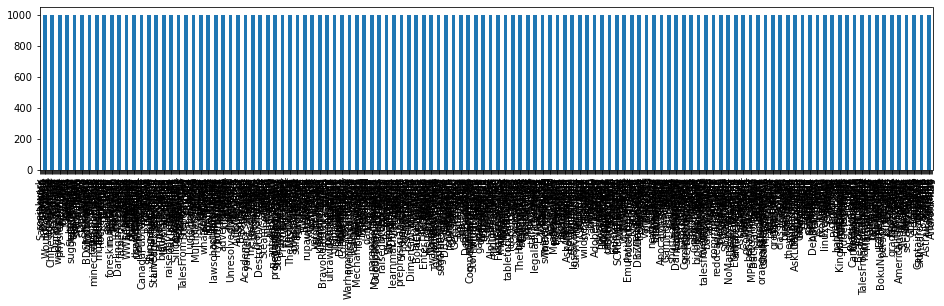

In [8]:
print(f"There are {labels.nunique()} unique labels in the set ")
fig,ax = plt.subplots(figsize = (16,3))
labels.value_counts().plot(ax=ax, kind='bar')
plt.show()

classes have been balanced! time to clean some of the punctation, and pseudo html from the text


In [9]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/dliu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text


df['selftext'] = df['selftext'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)


In [18]:
df.head()

,id,subreddit,title,selftext
0,6d8knd,talesfromtechsupport,remember command line switches,hi usual long time lerker first time poster ki...
1,58mbft,teenmom,matt addicted,ever say addiction still chugging beers talkin...
2,8f73s7,Harley,club colors,funny story went college las vegas knew anythi...
3,6ti6re,ringdoorbell,door bell floodlight mount height,know sub ring doorbell anyone used floodlight ...
4,77sxto,intel,worried 8700k small fft data stress results,prime95 regardless version occt small tests in...


At this point we can consider if we want to prepend the title to the post, or handel it as a separate feature. i think for simplicity, the first time, we will just use the post only then compare to results with title + selftext 

In [21]:
X = df.selftext
y = df.subreddit
X_train,  X_test, y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [20]:
# setup a naive bayesian classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer